In [34]:
from starspot import Star as ST
from starspot import Spot as Spot

In [35]:
st1 = ST(no_evolution=True)
st1.simulate_spots()

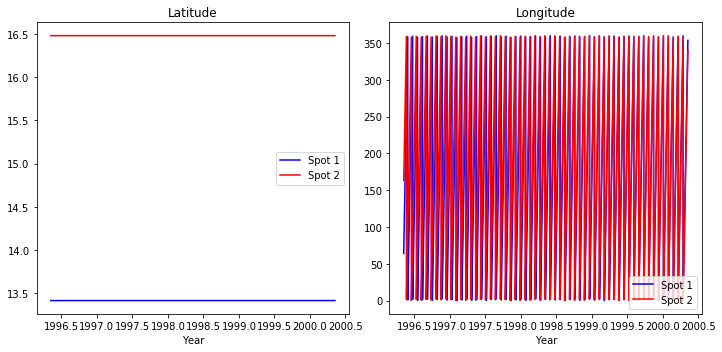

In [36]:
time = st1.spot_dict['1']['time']
lat1 = np.degrees(st1.spot_dict['1']['latitude'])
lat2 = np.degrees(st1.spot_dict['2']['latitude'])

lon1 = np.degrees(st1.spot_dict['1']['longitude'])
lon2 = np.degrees(st1.spot_dict['2']['longitude'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
flataxs = axs.flatten()
flataxs[0].plot(time, lat1, 'b', label='Spot 1')
flataxs[0].plot(time, lat2, 'r', label='Spot 2')
flataxs[0].set_xlabel('Year')
flataxs[0].set_title('Latitude')
flataxs[0].legend()

flataxs[1].plot(time, lon1, 'b', label='Spot 1')
flataxs[1].plot(time, lon2, 'r', label='Spot 2')
flataxs[1].set_xlabel('Year')
flataxs[1].set_title('Longitude')
flataxs[1].legend()

fig.tight_layout()
plt.show()

In [7]:
st1.spot_dict

{'1': {'time': array([1996.3525    , 1996.35295631, 1996.35341262, ..., 2000.35113107,
         2000.35158738, 2000.35204369]),
  'area': array([10., 10., 10., ..., 10., 10., 10.]),
  'latitude': array([0.00485734, 0.00485734, 0.00485734, ..., 0.00485734, 0.00485734,
         0.00485734]),
  'longitude': array([0.03749324, 0.03760792, 0.0377226 , ..., 1.0424541 , 1.04256878,
         1.04268346])},
 '2': {'time': array([1996.3525    , 1996.35295631, 1996.35341262, ..., 2000.35113107,
         2000.35158738, 2000.35204369]),
  'area': array([10., 10., 10., ..., 10., 10., 10.]),
  'latitude': array([0.00292044, 0.00292044, 0.00292044, ..., 0.00292044, 0.00292044,
         0.00292044]),
  'longitude': array([0.09598477, 0.09609945, 0.09621413, ..., 1.10094865, 1.10106334,
         1.10117802])}}

In [20]:
np.random.normal(st1.latitude_mean, st1.latitude_sigma)

0.3701375960979077

In [17]:
st1.latitude_mean

0.2617993877991494